In [1]:
import sys; sys.path.append('../../wwa'); from wwa import *

In [4]:
sf = gpd.read_file("../../00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/sf_afghIranPak")
xn, xx, yn, yx = [37,80,15,50]

mapproj = cartopy.crs.PlateCarree()

In [74]:
gmst = pd.read_csv("ts/gmst.dat", comment = "#", sep =" +", engine = "python", header = None, index_col = 0, names = ["gmst"])
gmst.gmst - gmst.loc[slice(None, 1900),"gmst"].mean()

# HighResMIP

## List models with present + future SST runs

In [2]:
# `echo synda search variable=pr` > highresmip.txt

# get list of HighResMIP models with both present & future runs
df = pd.read_csv("highresmip.txt", sep = ".", header = None, names = ["x1", "x2", "inst", "model", "forcing", "member", "freq", "var", "grid", "version"])
df["id"] = [r.model +"_"+ r.member+"_"+r.grid for k, r in df.iterrows()]

mdl_ids = [m for m in df.loc[df.forcing == "highresSST-present", "id"] if m in list(df.loc[df.forcing == "highresSST-future", "id"])]

",".join(sorted(list(set([m.split("_")[0] for m in mdl_ids]))))

'CMCC-CM2-HR4,CMCC-CM2-VHR4,CNRM-CM6-1,CNRM-CM6-1-HR,EC-Earth3P,EC-Earth3P-HR,HadGEM3-GC31-HM,HadGEM3-GC31-LM,HadGEM3-GC31-MM,HiRAM-SIT-HR,HiRAM-SIT-LR,MPI-ESM1-2-HR,MPI-ESM1-2-XR'

In [3]:
ml = sorted(glob.glob("../../00_WWA_project_folder/ephemeral/synda_clair/data/highresmip/*"))
ml = [fpath.split("/")[-1] for fpath in ml if len(glob.glob(fpath+"/pr/*present*.nc")) and len(glob.glob(fpath+"/pr/*future*.nc"))]

print(sorted(ml))
print(len(ml))

['CMCC-CM2-HR4', 'CMCC-CM2-VHR4', 'EC-Earth3P', 'EC-Earth3P-HR', 'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'HadGEM3-GC31-MM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-XR']
9


## Precip time series

In [4]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/highresmip/"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/"

In [10]:
for mdl in ml:
    
    print(mdl)
    if os.path.exists(outpath+"pr-am_"+mdl+".nc"): continue
    
    # list all valid files
    fl_hist = sorted(glob.glob(fpath+mdl+"/pr/*present*.nc"))
    fl_fut = [fnm for fnm in sorted(glob.glob(fpath+mdl+"/pr/*future*.nc")) if fnm[-11:-7] <= "2050"]
    
    da_hist = xr.open_mfdataset(fl_hist)
    da_fut = xr.open_mfdataset(fl_fut)
    
    if da_fut.time[0] <= da_hist.time[-1]: da_fut = da_fut.sel(time = da_fut.time > da_hist.time[-1])
        
    da = xr.concat([da_hist, da_fut], "time")
    
    da = da.pr.sel(lon = slice(xn,xx), lat = slice(yn,yx)).load()
    am = [m in [4,5] for m in da.time.dt.month]
    
    # spatial pattern
    sp = da.sel(time = am).sel(time = slice("1991","2020")).resample(time = "AS").sum().mean("time")
    sp.to_netcdf(outpath+"pr-am-spatial_"+mdl+".nc")
    
    # daily time series
    rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
    ts = da.where(rm == 0).mean(["lat", "lon"])
    
    # seasonal cycle
    sc = ts.sel(time = slice("1991","2020")).groupby("time.dayofyear").mean()
    sc.to_netcdf(outpath+"pr_seasonal_"+mdl+".nc")

    # April-May
    ts_am = ts.sel(time = am).resample(time = "AS").sum()
    ts_am.to_netcdf(outpath+"pr-am_"+mdl+".nc")

CMCC-CM2-VHR4
EC-Earth3P
HadGEM3-GC31-HM
EC-Earth3P-HR


/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


MPI-ESM1-2-XR
CMCC-CM2-HR4
HadGEM3-GC31-LM
MPI-ESM1-2-HR
HadGEM3-GC31-MM


## Time series for climate explorer

In [28]:
for fnm in glob.glob(outpath+"pr-am_*.nc"):
    
    mdl = fnm.split("_")[-1][:-3]
    ts = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

    csv_fnm = "Afghanistan-floods_pr-am_highresmip_"+mdl
    csv_fullpath = "ts_highresmip/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: HighResMIP "+mdl+" April-May accumulated precipitation - Afghanistan floods 2024, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm/2month] April-May accumulated precipitation over Afghanistan, Iran and Pakistan at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)
    
print("Done.")

Done.


## Seasonal cycle

In [35]:
era5 = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/patterns_for_validation/era5_sc_1991_2020.nc").tp
mswep = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/patterns_for_validation/mswep_sc_1991_2020.nc").precipitation

In [42]:
fl = sorted(glob.glob(outpath+"pr_seasonal*"))

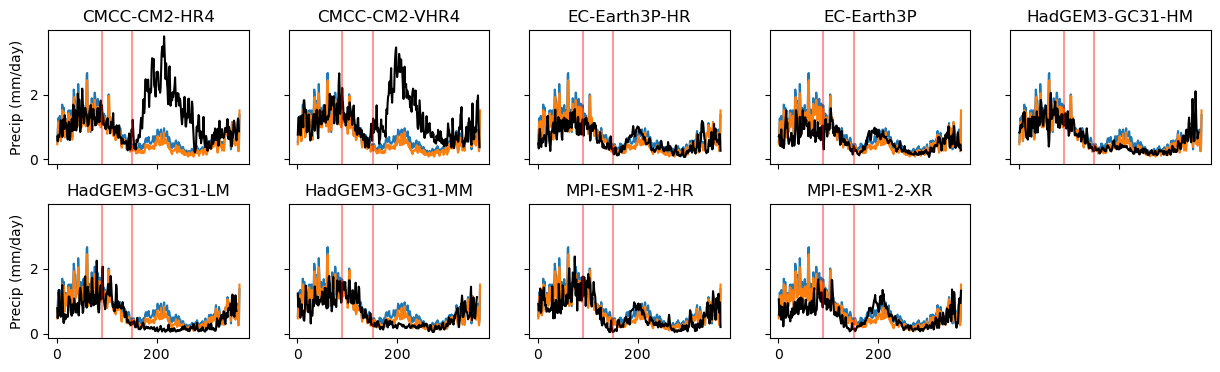

In [70]:
nc = 5; nr = 2

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 3, nr * 2), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    ax = fig.axes[i]
    
    era5.plot(ax = ax)
    mswep.plot(ax = ax)
    
    sc = convert_units_to(xr.open_dataset(fl[i]).pr, "mm/day")
    sc.plot(ax = ax, color = "k")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(fl[i].split("_")[-1][:-3])
    
    [ax.axvline(x, color = "red", alpha = 0.4) for x in [90.5, 151.5]]
    
for ax in axs[:,0]: ax.set_ylabel("Precip (mm/day)")
if nc * nr > len(fl):
    for j in range(len(fl), nc * nr): fig.axes[j].set_axis_off()
        
plt.savefig("fig/model-eval_highresmip_seasonal-cycle_plots.png")

## Spatial pattern

In [72]:
era5 = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/patterns_for_validation/era5_AM_clim1991-2020.nc").tp
mswep = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/patterns_for_validation/mswep_AM_clim1991-2020.nc").precipitation

In [74]:
fl = sorted(glob.glob(outpath+"pr-am-spatial*"))

['/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/pr-am-spatial_CMCC-CM2-HR4.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/pr-am-spatial_CMCC-CM2-VHR4.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/pr-am-spatial_EC-Earth3P-HR.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/pr-am-spatial_EC-Earth3P.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/pr-am-spatial_HadGEM3-GC31-HM.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/pr-am-spatial_HadGEM3-GC31-LM.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/highresmip/pr-am-spatial_HadGEM3-GC31-MM.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanista

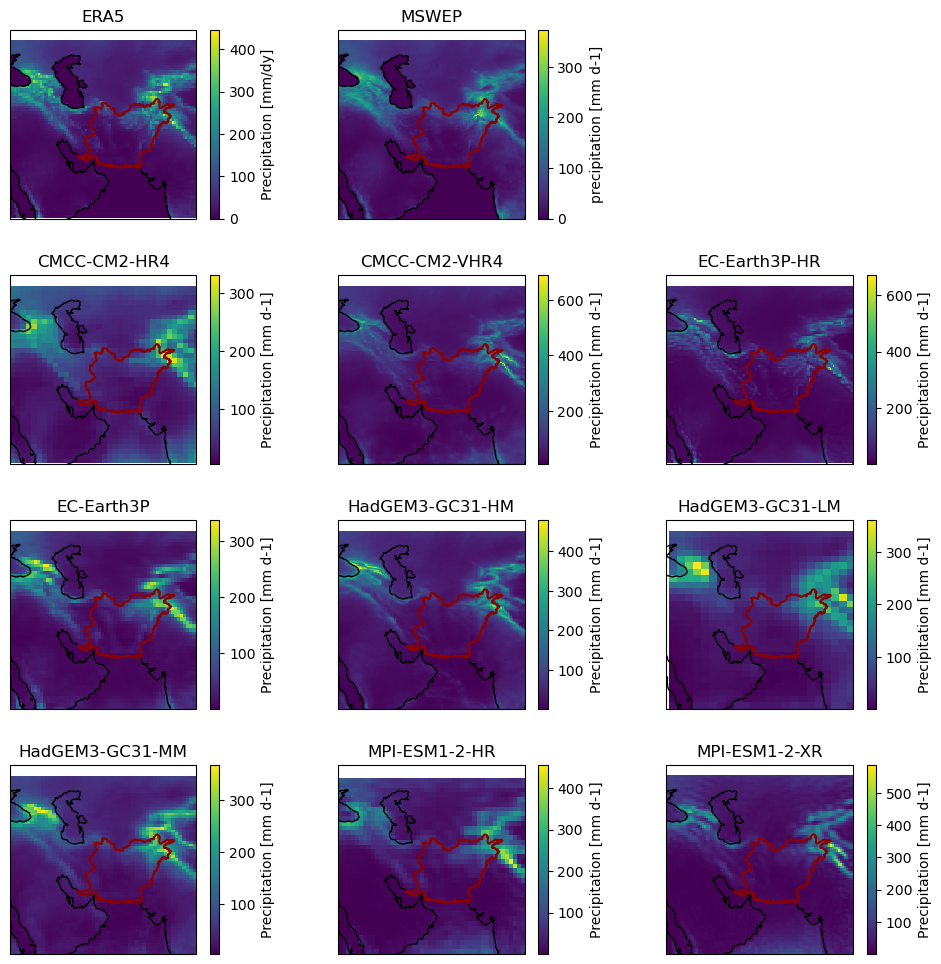

In [90]:
nc = 3; nr = 3

fig, axs = plt.subplots(ncols = nc, nrows = nr+1, figsize = (nc * 4, (nr+1) * 3), dpi = 100, sharex = True, sharey = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(hspace = 0.3)

plot_kwargs = {"vmin" : 0}

ax = axs[0,0]
era5.plot(ax = ax)
ax.set_title("ERA5")

ax = axs[0,1]
mswep.plot(ax = ax)
ax.set_title("MSWEP")

axs[0,2].set_axis_off()

for ax in axs[0,:2]:
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")

for i in range(len(fl)):
    ax = fig.axes[nc+i]

    sp = convert_units_to(xr.open_dataset(fl[i]).pr, "mm/day")
    sp.plot(ax = ax)
#     ax.set_xlabel("")
#     ax.set_ylabel("")
    ax.set_title(fl[i].split("_")[-1][:-3])
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    
#     [ax.axvline(x, color = "red", alpha = 0.4) for x in [90.5, 151.5]]
    
# for ax in axs[:,0]: ax.set_ylabel("Precip (mm/day)")
if nc * nr > len(fl):
    for j in range(len(fl)+nc, (nc+1) * nr): fig.axes[j].set_axis_off()
        
plt.savefig("fig/model-eval_highresmip_spatial-pattern_plots.png")

## Trends after 1979

In [35]:
era5 = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/patterns_for_validation/era5_sc_1991_2020.nc").tp
mswep = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Afghanistan/Afghanistan/patterns_for_validation/mswep_sc_1991_2020.nc").precipitation

In [34]:
fl = sorted(glob.glob("ts_highresmip/*.dat"))

In [44]:
fnm.split("_")[-1][:-4]

'CMCC-CM2-HR4'

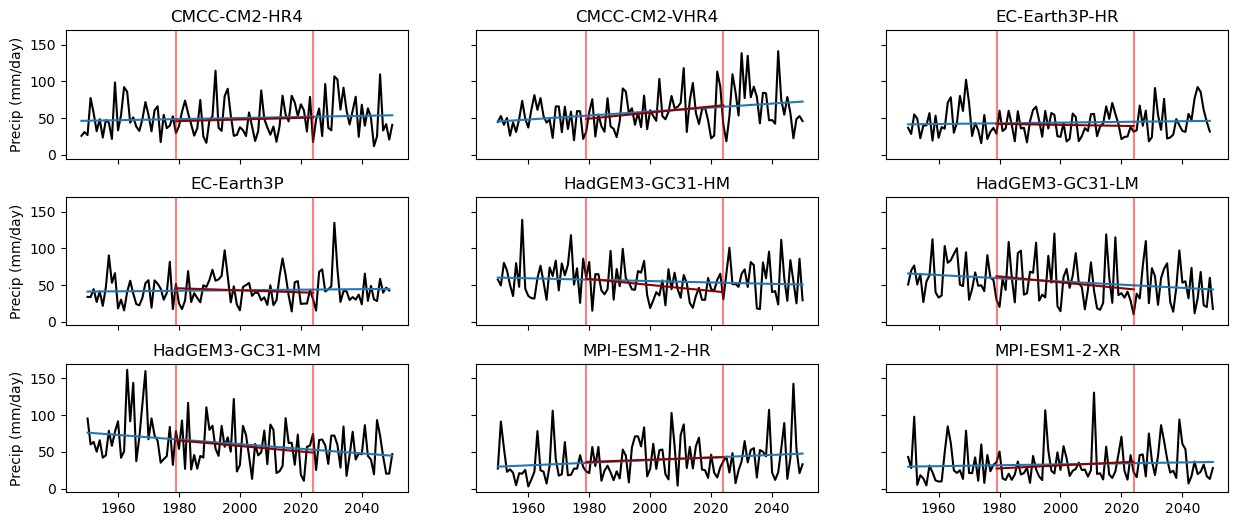

In [54]:
nc = 3; nr = 3

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 2), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    ax = fig.axes[i]
    
    fnm = fl[i]
    mdl = fnm.split("_")[-1][:-4]
    ts = pd.read_csv(fnm, comment = "#", sep = " ", header = None, index_col = 0, names = ["pr"])
    
    ts.plot(ax = ax, color = "k", legend = False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(mdl)
    
    xyline(ts.index, ts.pr, ax = ax)
    xyline(ts.loc[slice(1979,2024)].index, ts.loc[slice(1979,2024)].pr, ax = ax, color = "darkred")
    
    [ax.axvline(x, color = "red", alpha = 0.5) for x in [1979, 2024]]
    
for ax in axs[:,0]: ax.set_ylabel("Precip (mm/day)")
if nc * nr > len(fl):
    for j in range(len(fl), nc * nr): fig.axes[j].set_axis_off()
        
# plt.savefig("fig/model-eval_highresmip_trends.png")

# CMIP6

In [52]:
ml = glob.glob("../../00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/*")
ml = [fpath.split("/")[-1] for fpath in ml if len(glob.glob(fpath+"/pr/*ssp*.nc")) > 0 and len(glob.glob(fpath+"/pr/*hist*.nc")) > 0]

print(ml)
print(len(ml))

['IPSL-CM6A-LR', 'ACCESS-CM2', 'KACE-1-0-G', 'NorESM2-LM', 'CanESM5', 'ACCESS-ESM1-5', 'CMCC-ESM2', 'EC-Earth3-Veg-LR', 'EC-Earth3', 'EC-Earth3-Veg', 'CMCC-CM2-SR5', 'MIROC6', 'NorESM2-MM', 'MRI-ESM2-0']
14


In [39]:
fpath = '../../00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/IPSL-CM6A-LR'

In [45]:
fl = glob.glob(fpath+"/pr/*.nc")[1:]

In [50]:
xr.open_dataset(fl[1]).pr

<xarray.DataArray 'pr' (time: 60265, lat: 143, lon: 144)>
[1240976880 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    long_name:           Precipitation
    units:               kg m-2 s-1
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 d
    standard_name:       precipitation_flux
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    cell_measures:       area: areacella

In [51]:
ml = glob.glob("../../00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/*")
ml = [fpath.split("/")[-1] for fpath in ml if len(glob.glob(fpath+"/pr/*ssp*.nc")) == 0 and len(glob.glob(fpath+"/pr/*hist*.nc")) == 0 ]

print(ml)
print(len(ml))

['AWI-CM-1-1-MR', 'INM-CM5-0', 'MPI-ESM1-2-LR', 'INM-CM4-8', 'MPI-ESM1-2-HR']
5


# ERA5

In [27]:
da = xr.open_dataset("data/era5_tp_daily_37-80E_15-50N.nc").tp

rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
da = da.where(rm == 0).mean(["lat", "lon"])

ts = da.resample(time = "MS").sum().rolling(time = 2, center = False).sum().groupby("time.month")[5]
ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

In [30]:
csv_fnm = "Afghanistan-floods_pr-am_obs_era5"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 April-May accumulated precipitation - Afghanistan floods 2024, c.barnes22@imperial.ac.uk"
str2 = "# pr [mm/2month] April-May accumulated precipitation over Afghanistan, Iran and Pakistan at "+csv_fnm+".dat"
head = "# year pr"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

# GPCC

In [24]:
da = decode_times(xr.open_dataset("data/gpcc_025_37-80E_15-50N.nc", decode_times = False)).precip
rm = regionmask.mask_geopandas(sf, da.lon, da.lat)
da = da.where(rm == 0).mean(["lat", "lon"])

ts = da.resample(time = "MS").sum().rolling(time = 2, center = False).sum().groupby("time.month")[5]
ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

csv_fnm = "Afghanistan-floods_pr-am_obs_gpcc"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: GPCC April-May accumulated precipitation - Afghanistan floods 2024, c.barnes22@imperial.ac.uk"
str2 = "# pr [mm/2month] April-May accumulated precipitation over Afghanistan, Iran and Pakistan at "+csv_fnm+".dat"
head = "# year pr"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

---
---
# **Synthesis plots**

In [91]:
varnm = "nino"
time = "neut"

df = {t+"_"+time : pd.read_fwf("synthesis/synth_"+varnm+"_"+t+"_"+time+".txt", comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")for t in ["pr", "dI"]}

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,len(df["dI_"+time]) * 3/8), dpi = 100, sharey = "row", sharex = "col")
plt.subplots_adjust(wspace = 0.07, hspace = 0.1)

pr_ax = axs[0]; di_ax = axs[1]

gcols = ["blue", "blue", "red", "red", "magenta"]
galpha = [0.5,1,0.5,1,1]

di_ax.axvline(0, ls = "--", color = "k", lw = 1, zorder = -99)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(2):
        
        ax = axs[i]
        ds = ["pr", "dI"][i] + "_"+time
        res = df[ds]
        ttl = "("+["a","b"][i]+ ") "+["Probability ratio", "% change in intensity"][i]
        
        ax.set_title(ttl)
        
        ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
        
        for k in range(len(res)):
            
            r = res.iloc[k]
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
            ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[int(r.group)-1], alpha = galpha[int(r.group)-1]))

            ax.plot(r.est, -k, color = "k", marker = "v")  
            
pr_ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
pr_ax.set_xscale('log') 
xx = [10**x for x in range(-4,10,2)]
pr_ax.set_xticks(xx)
pr_ax.set_xticklabels([format(x,",") if not x in [10**6] else "" for x in xx])

pr_ax.set_yticks(range(0, -len(df["pr_"+time]), -1))
pr_ax.set_yticklabels([re.sub('"', '', r).strip() for r in df["pr_"+time].index])

pr_ax.set_xlim(10**-6,10**10)
di_ax.set_xlim(-100,200)

plt.savefig("fig/synthesis_"+varnm+".png")